# 6) Gray Matter Area Segmentation

Using DSA based annotations to get the gray matter area for each Emory image and also to save the png of the gray matter mask. Mirrors the anlaysis for Tissue area segmentation except that the segmentation was done by hand.

The annotations are pre-saved into json files.

In [1]:
import json
import os
from os.path import join as oj
import pandas as pd
import matplotlib.pyplot as plt
import pyvips as Vips
import numpy as np
from copy import deepcopy
from PIL import Image, ImageDraw
import imageio
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")


In [2]:
# from https://github.com/jcupitt/libvips/blob/master/doc/Examples.md
NP_DTYPE_TO_VIPS_FORMAT = {
        np.dtype('int8'): Vips.BandFormat.CHAR,
        np.dtype('uint8'): Vips.BandFormat.UCHAR,
        np.dtype('int16'): Vips.BandFormat.SHORT,
        np.dtype('uint16'): Vips.BandFormat.USHORT,
        np.dtype('int32'): Vips.BandFormat.INT,
        np.dtype('float32'): Vips.BandFormat.FLOAT,
        np.dtype('float64'): Vips.BandFormat.DOUBLE
    }
VIPS_FORMAT_TO_NP_DTYPE = {v:k for k, v in NP_DTYPE_TO_VIPS_FORMAT.items()}


def array_vips(vips_image, verbose=False):
    dtype = VIPS_FORMAT_TO_NP_DTYPE[vips_image.format]
    if verbose:
        # (height, width, channels)
        print("dtype: {}, shape: ({}, {}, {})".
            format(dtype, vips_image.height, vips_image.width, vips_image.bands)
        )
    return (np.frombuffer(vips_image.write_to_memory(), dtype=dtype).
        reshape(vips_image.height, vips_image.width, vips_image.bands))


def get_lr_res(wsi_path, level=2):
    """Get a low res image from a WSI using pyvips
    
    :param wsi_path : str
        path to WSI image
    :param level : int (default: 2)
        level to to get image at, 0 is full res
        
    :return arr_im : int
        low res image
    """
    # get low res image
    vips_im = Vips.Image.new_from_file(wsi_path, level=level)
    
    arr_im = array_vips(vips_im)
        
    return arr_im


def transform_annotations(annotations, fr_shape, lr_shape):
    """transorm annotations from full resolution to lower resolution
    shape : (height, width)
    """
    # calculate the reshape factor for each dimension
    x_factor = lr_shape[1] / fr_shape[1]
    y_factor = lr_shape[0] / fr_shape[0]
    
    lr_annotations = deepcopy(annotations)
    # each annotations name
    
    # for each group annotations
    for group, v in annotations.items():
        if group in ['width', 'height']:
            continue
        # for each specific annotations
        for i, points in enumerate(v):
            mod_points = [(int(p[0]*x_factor),(int(p[1]*y_factor))) for p in points]
            lr_annotations[group][i] = mod_points
    return lr_annotations


def make_gm_mask(target_shape, annotations):
    
    mask = Image.new('L', (target_shape[1], target_shape[0]))
    for points in annotations['white_matter']:
        ImageDraw.Draw(mask).polygon(points, outline=255, fill=255)
        
    if 'negative' in annotations:
        for points in annotations['negative']:
            ImageDraw.Draw(mask).polygon(points, outline=0, fill=0)
    
    mask = np.array(mask)
    return mask


def plot_arrays(im, mask, name):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].imshow(im[:,:,:3])
    ax[0].set_title(name, fontweight="bold", fontsize=16)
    ax[1].imshow(mask.squeeze()/np.max(mask), cmap=plt.get_cmap("gist_ncar"))
    plt.show()
    

#### <center>Run</center>

In [3]:
# note that the masks should be the same shape as the confidence heatmaps for later masking
# so modify the masks here
"""***Parameters***"""
heatmaps_dir = '/mnt/Data/outputs/heatmaps_emory/'
ann_path = '../jsons/gm_annotations.json'
save_dir = '/mnt/Data/outputs/gm_masks/'
wsi_dir = '/mnt/Data/wsi/Dataset_Emory/'
csv_path = '../CSVs/Emory_data.csv'

os.makedirs(save_dir, exist_ok=True)

with open(ann_path, 'rb') as fp:
    anns = json.load(fp)

# get paths to Emory hm
hm_paths = {}
for r, d, f in os.walk(heatmaps_dir):
    for file in f:
        if '.npy' in file:
            hm_paths[file.replace('.npy', '')] = oj(r, file)

file_paths = {}
for r, d, f in os.walk(wsi_dir):
    for file in f:
        if '.svs' in file:
            file_paths[file.replace('.svs', '')] = oj(r, file)


For each heatmap, create a binary mask for the gm in the same size as the image pulled from PyVips as level 2. This is to match the same resolution used in the tissue area calculation.

For saving the actualy binary masks as images use the resolution of the confidence heatmaps.


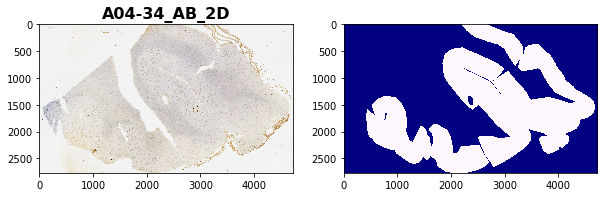

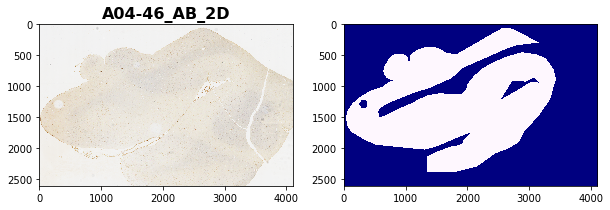

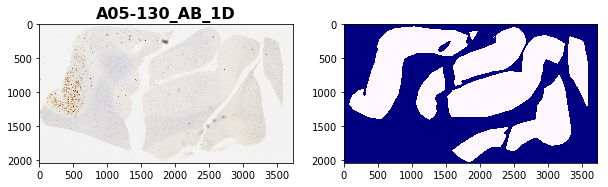

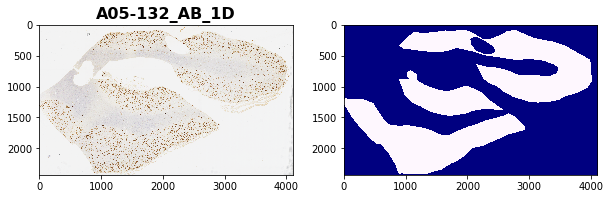

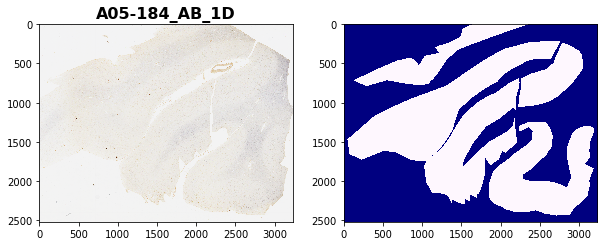

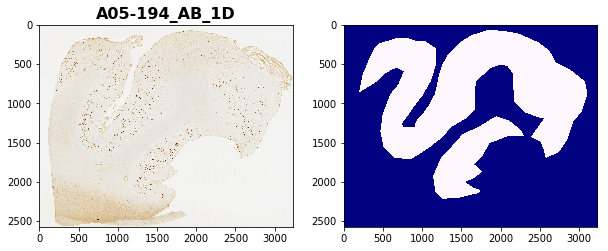

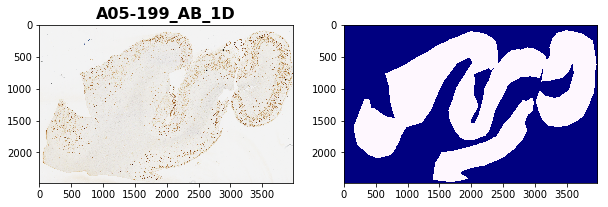

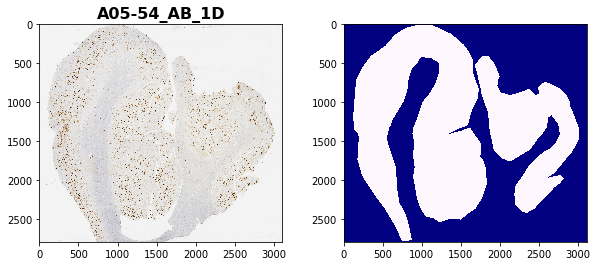

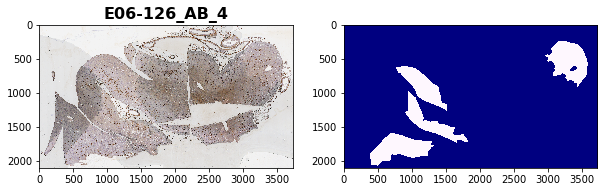

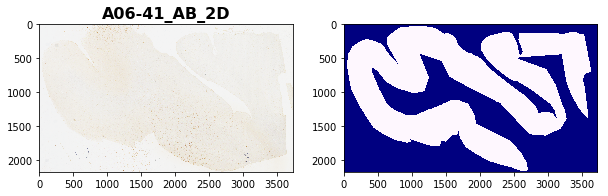

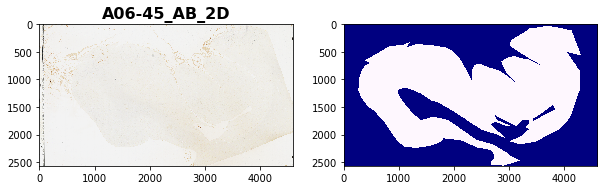

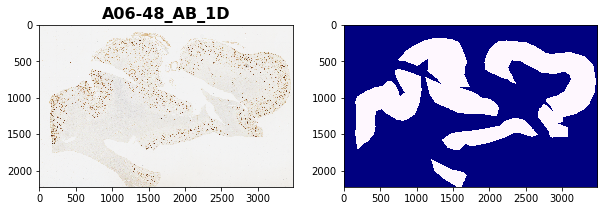

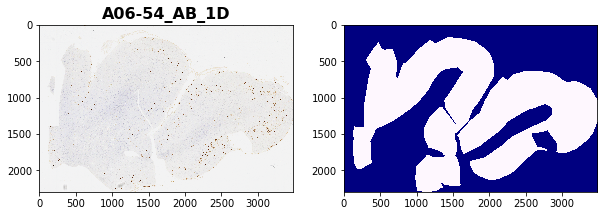

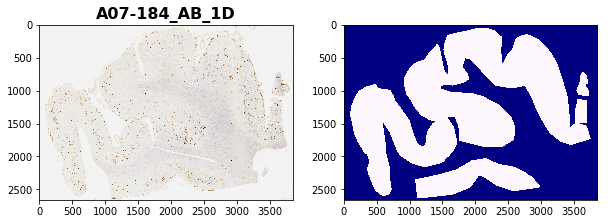

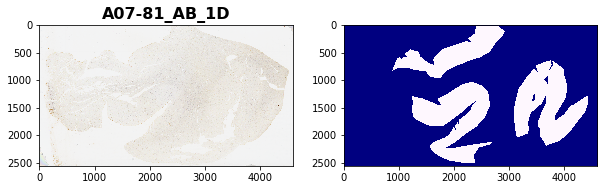

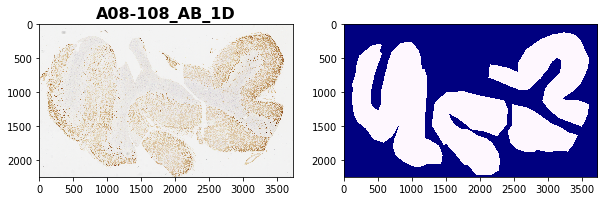

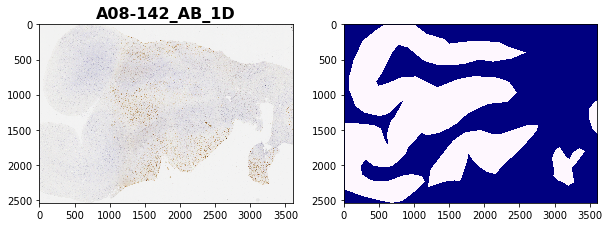

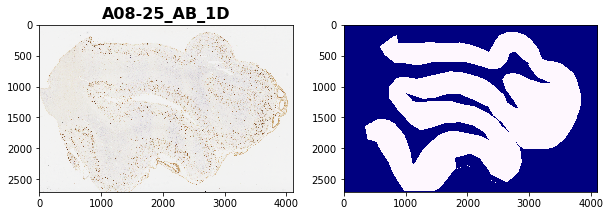

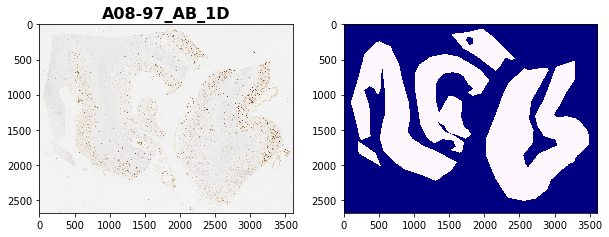

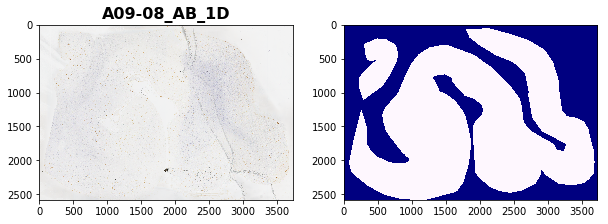

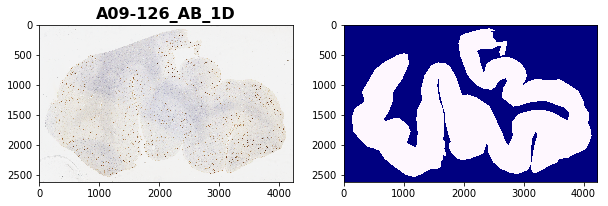

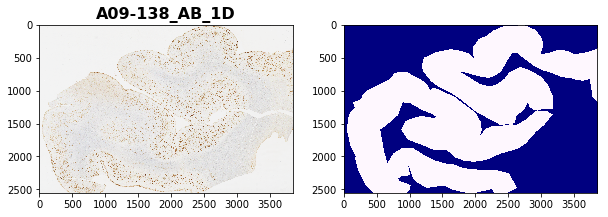

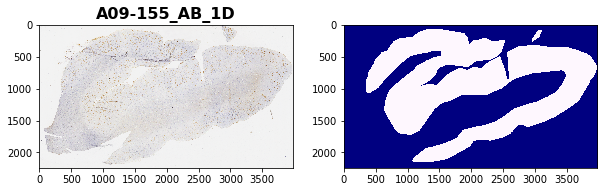

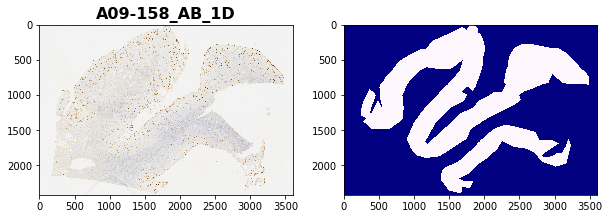

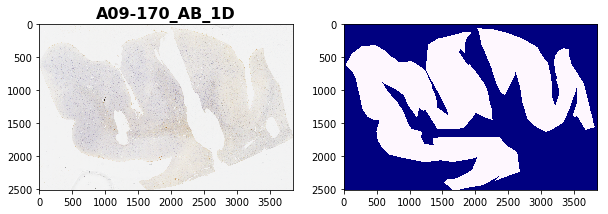

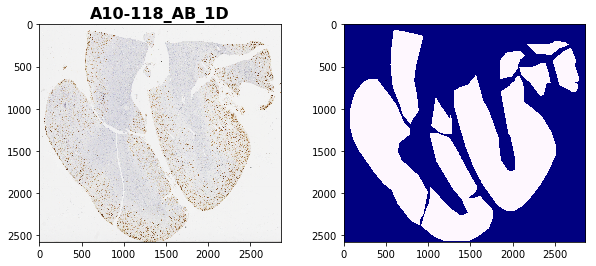

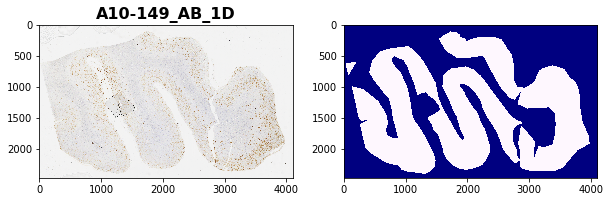

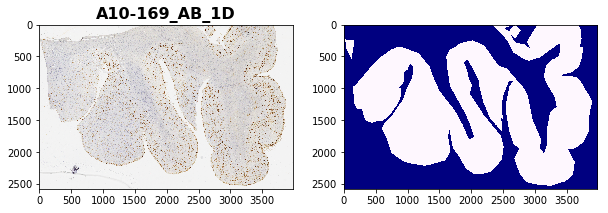

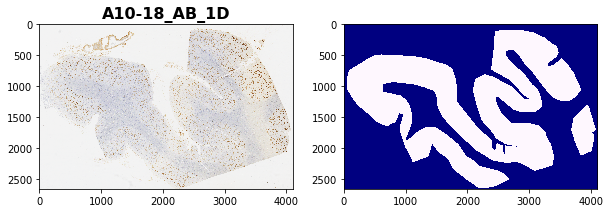

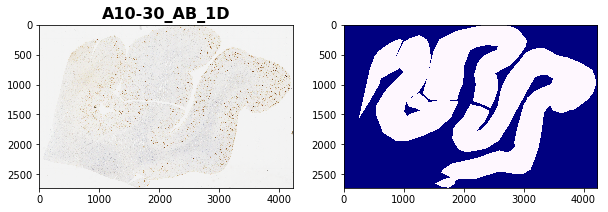

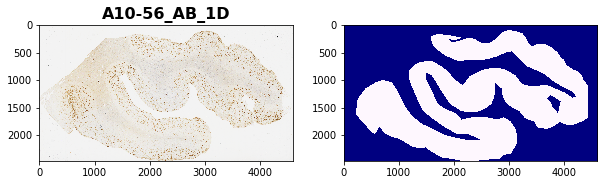

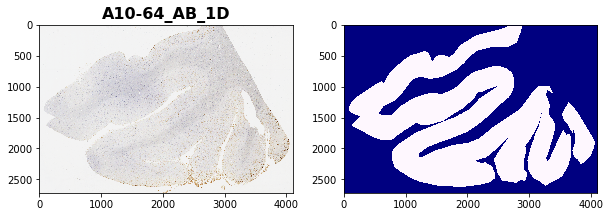

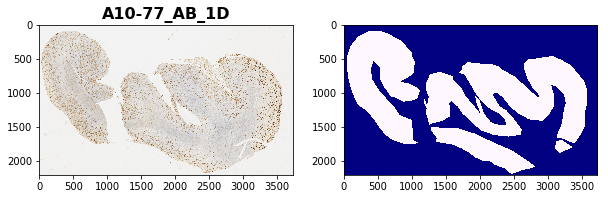

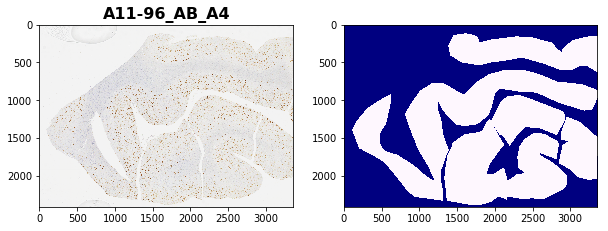

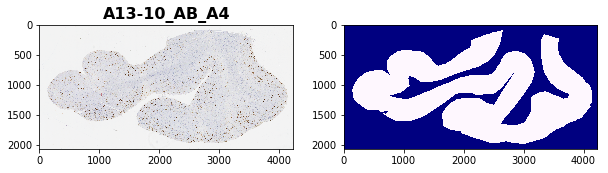

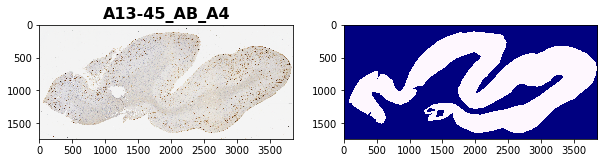

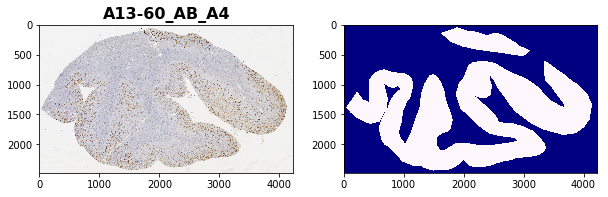

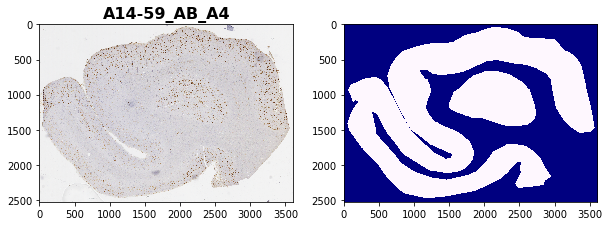

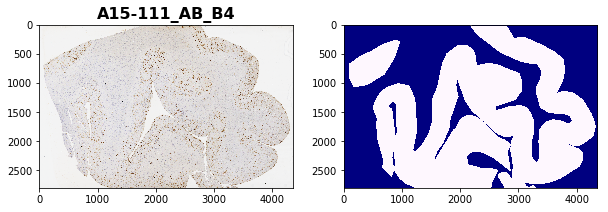

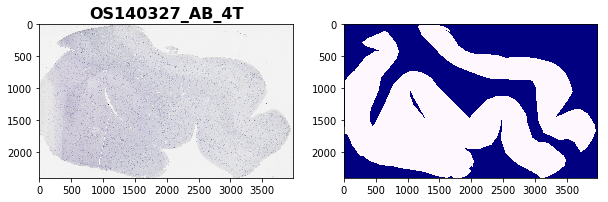

In [4]:
df = pd.read_csv(csv_path)
    
gm_areas = []
for i, r in df.iterrows():
    # get the image at level 2 using PyVips to match same resolution used when calculating tissue pixel areas
    filename = r['WSI_ID']
    file_path = file_paths[filename]
    lr_im = get_lr_res(file_path)
    
    # from annotations at full res get the appropriate mask at low res to get the gm area count
    A = anns[filename]
    lr_shape= lr_im.shape[:-1]  # (height, width)
    fr_shape = A['height'], A['width']
    
    a = transform_annotations(A, fr_shape, lr_shape)
    mask = make_gm_mask(lr_im.shape[:-1], a)
    gm_areas.append((mask>0).sum())
    
    plot_arrays(lr_im, mask, filename)
    
    # for saving - first read in the confidence heatmap to get its shape and resize binary mask to that shape
    # transform annotations must take into account the padding of the norm tiles process
    tile_dim = 1536
    xpad = tile_dim - fr_shape[1] % tile_dim
    ypad = tile_dim - fr_shape[0] % tile_dim
    fr_shape = fr_shape[0] + ypad, fr_shape[1] + xpad
    hm = np.load(hm_paths[filename])[0]
    lr_shape = hm.shape
    a = transform_annotations(A, fr_shape, lr_shape)
    mask = make_gm_mask(lr_shape, a)
    
    # save mask as image
    imageio.imwrite(oj(save_dir, filename + '.png'), mask)

# add area column
df['gm_px_count'] = gm_areas

# save the df
df.to_csv(csv_path, index=False)


In [5]:
df.head()

WSI_ID  Cored_MTG  Diffuse_MTG  CAA_MTG Primary Dx Secondary Dx (1)  \
0   A04-34_AB_2D          0            1        0    control             none   
1   A04-46_AB_2D          0            0        1    control             none   
2  A05-130_AB_1D          0            3        0    control             none   
3  A05-132_AB_1D          2            3        1         AD              DLB   
4  A05-184_AB_1D          0            1        0    control          poss AD   

  Secondary Dx (2)     Sex  Age at Death   PMI                    Race Reagan  \
0             none  Female            57  17.0  Black/African American     no   
1             none    Male            40  31.0               Caucasian     no   
2             none  Female            52   3.0               Caucasian     no   
3             none    Male            58  12.5               Caucasian   high   
4             none    Male            81  20.0               Caucasian    low   

   tissue_px_count  gm_px_count  
0          7636650      4940954  
1          7162534      4428261  
2          4635240      3372416  
3          5204949      3593017  
4          5497260      3821066